<a href="https://colab.research.google.com/github/miguel-fc/PyTorch-tools/blob/main/CNAuto_pytorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import gdown
import sys

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!cp /content/gdrive/MyDrive/Pytorch-tools-gdrive/CA.py .

In [4]:
import CA

In [5]:
print('Training samples:',len(train_dataset))
print('Test samples:',len(test_dataset))

print('Tensor size:',train_dataset[0][0].size())
print('First 10 digits are:', [train_dataset[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [6]:
print('Min intensity value: ',train_dataset[0][0].min().item())
print('Max intensity value: ',train_dataset[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


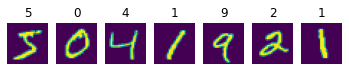

In [7]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(train_dataset[i][0].view(28,28))
    ax[i].set_title(train_dataset[i][1])
    ax[i].axis('off')

In [8]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = CA.Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = CA.Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [9]:
# Move both the encoder and the decoder to the selected device
encoder.to(device)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [10]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [11]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

	 partial train loss (single batch): 0.252991
	 partial train loss (single batch): 0.246634
	 partial train loss (single batch): 0.240321
	 partial train loss (single batch): 0.236063
	 partial train loss (single batch): 0.232337
	 partial train loss (single batch): 0.228580
	 partial train loss (single batch): 0.225877
	 partial train loss (single batch): 0.222385
	 partial train loss (single batch): 0.220145
	 partial train loss (single batch): 0.218152
	 partial train loss (single batch): 0.215569
	 partial train loss (single batch): 0.213515
	 partial train loss (single batch): 0.211700
	 partial train loss (single batch): 0.209733
	 partial train loss (single batch): 0.207002
	 partial train loss (single batch): 0.205374
	 partial train loss (single batch): 0.203590
	 partial train loss (single batch): 0.201560
	 partial train loss (single batch): 0.200003
	 partial train loss (single batch): 0.197400
	 partial train loss (single batch): 0.195824
	 partial train loss (single batch

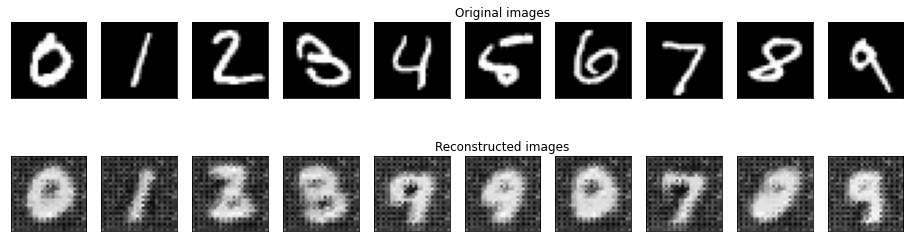

	 partial train loss (single batch): 0.066471
	 partial train loss (single batch): 0.064840
	 partial train loss (single batch): 0.066977
	 partial train loss (single batch): 0.065878
	 partial train loss (single batch): 0.065062
	 partial train loss (single batch): 0.063532
	 partial train loss (single batch): 0.063619
	 partial train loss (single batch): 0.065775
	 partial train loss (single batch): 0.064834
	 partial train loss (single batch): 0.063060
	 partial train loss (single batch): 0.064832
	 partial train loss (single batch): 0.064364
	 partial train loss (single batch): 0.063462
	 partial train loss (single batch): 0.063419
	 partial train loss (single batch): 0.063119
	 partial train loss (single batch): 0.064016
	 partial train loss (single batch): 0.062951
	 partial train loss (single batch): 0.063383
	 partial train loss (single batch): 0.061947
	 partial train loss (single batch): 0.063059
	 partial train loss (single batch): 0.061997
	 partial train loss (single batch

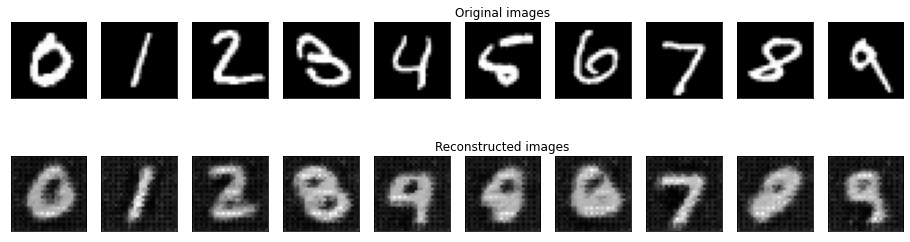

	 partial train loss (single batch): 0.048225
	 partial train loss (single batch): 0.046489
	 partial train loss (single batch): 0.048620
	 partial train loss (single batch): 0.047728
	 partial train loss (single batch): 0.047125
	 partial train loss (single batch): 0.045171
	 partial train loss (single batch): 0.045321
	 partial train loss (single batch): 0.048598
	 partial train loss (single batch): 0.047780
	 partial train loss (single batch): 0.045180
	 partial train loss (single batch): 0.048070
	 partial train loss (single batch): 0.047437
	 partial train loss (single batch): 0.046857
	 partial train loss (single batch): 0.046203
	 partial train loss (single batch): 0.047302
	 partial train loss (single batch): 0.047905
	 partial train loss (single batch): 0.046474
	 partial train loss (single batch): 0.047244
	 partial train loss (single batch): 0.045926
	 partial train loss (single batch): 0.047831
	 partial train loss (single batch): 0.046371
	 partial train loss (single batch

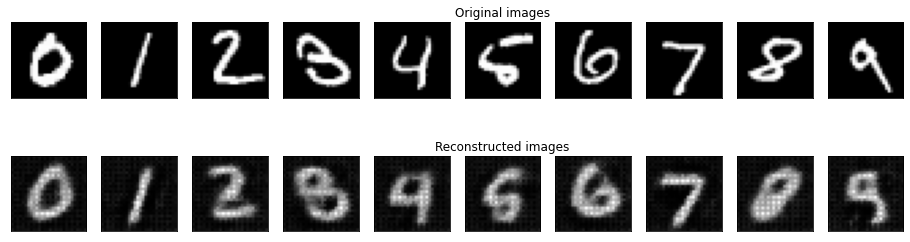

	 partial train loss (single batch): 0.039606
	 partial train loss (single batch): 0.038134
	 partial train loss (single batch): 0.039429
	 partial train loss (single batch): 0.038870
	 partial train loss (single batch): 0.038447
	 partial train loss (single batch): 0.036582
	 partial train loss (single batch): 0.036625
	 partial train loss (single batch): 0.039651
	 partial train loss (single batch): 0.039105
	 partial train loss (single batch): 0.036323
	 partial train loss (single batch): 0.039505
	 partial train loss (single batch): 0.038547
	 partial train loss (single batch): 0.038318
	 partial train loss (single batch): 0.037075
	 partial train loss (single batch): 0.038885
	 partial train loss (single batch): 0.039287
	 partial train loss (single batch): 0.037406
	 partial train loss (single batch): 0.038557
	 partial train loss (single batch): 0.037155
	 partial train loss (single batch): 0.038904
	 partial train loss (single batch): 0.037488
	 partial train loss (single batch

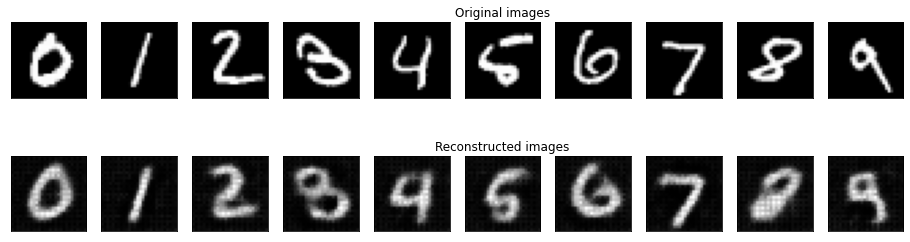

	 partial train loss (single batch): 0.034680
	 partial train loss (single batch): 0.033714
	 partial train loss (single batch): 0.034527
	 partial train loss (single batch): 0.034035
	 partial train loss (single batch): 0.033661
	 partial train loss (single batch): 0.031857
	 partial train loss (single batch): 0.031791
	 partial train loss (single batch): 0.034267
	 partial train loss (single batch): 0.034353
	 partial train loss (single batch): 0.031622
	 partial train loss (single batch): 0.034986
	 partial train loss (single batch): 0.033781
	 partial train loss (single batch): 0.034098
	 partial train loss (single batch): 0.032379
	 partial train loss (single batch): 0.034586
	 partial train loss (single batch): 0.034576
	 partial train loss (single batch): 0.032618
	 partial train loss (single batch): 0.034135
	 partial train loss (single batch): 0.032787
	 partial train loss (single batch): 0.034512
	 partial train loss (single batch): 0.033201
	 partial train loss (single batch

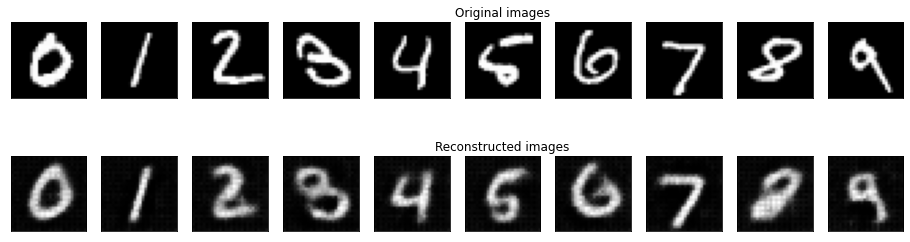

	 partial train loss (single batch): 0.032291
	 partial train loss (single batch): 0.031618
	 partial train loss (single batch): 0.032277
	 partial train loss (single batch): 0.031939
	 partial train loss (single batch): 0.031665
	 partial train loss (single batch): 0.029595
	 partial train loss (single batch): 0.029646
	 partial train loss (single batch): 0.031871
	 partial train loss (single batch): 0.032328
	 partial train loss (single batch): 0.029449
	 partial train loss (single batch): 0.032789
	 partial train loss (single batch): 0.031792
	 partial train loss (single batch): 0.032392
	 partial train loss (single batch): 0.030207
	 partial train loss (single batch): 0.032665
	 partial train loss (single batch): 0.032556
	 partial train loss (single batch): 0.030362
	 partial train loss (single batch): 0.031882
	 partial train loss (single batch): 0.030844
	 partial train loss (single batch): 0.032598
	 partial train loss (single batch): 0.031287
	 partial train loss (single batch

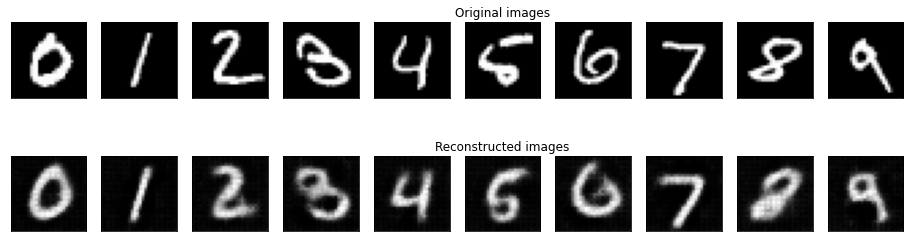

	 partial train loss (single batch): 0.031209
	 partial train loss (single batch): 0.030359
	 partial train loss (single batch): 0.030957
	 partial train loss (single batch): 0.030975
	 partial train loss (single batch): 0.030581
	 partial train loss (single batch): 0.028300
	 partial train loss (single batch): 0.028532
	 partial train loss (single batch): 0.030570
	 partial train loss (single batch): 0.031287
	 partial train loss (single batch): 0.028236
	 partial train loss (single batch): 0.031701
	 partial train loss (single batch): 0.030668
	 partial train loss (single batch): 0.031292
	 partial train loss (single batch): 0.029069
	 partial train loss (single batch): 0.031752
	 partial train loss (single batch): 0.031388
	 partial train loss (single batch): 0.029097
	 partial train loss (single batch): 0.030602
	 partial train loss (single batch): 0.029644
	 partial train loss (single batch): 0.031513
	 partial train loss (single batch): 0.030361
	 partial train loss (single batch

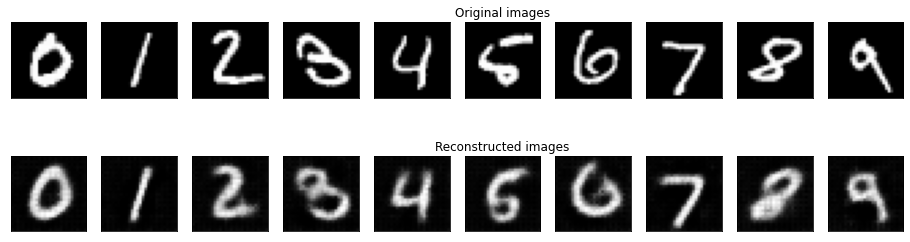

	 partial train loss (single batch): 0.030520
	 partial train loss (single batch): 0.029635
	 partial train loss (single batch): 0.030132
	 partial train loss (single batch): 0.030262
	 partial train loss (single batch): 0.029993
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.027541
	 partial train loss (single batch): 0.029723
	 partial train loss (single batch): 0.030636
	 partial train loss (single batch): 0.027417
	 partial train loss (single batch): 0.030982
	 partial train loss (single batch): 0.030002
	 partial train loss (single batch): 0.030635
	 partial train loss (single batch): 0.028376
	 partial train loss (single batch): 0.031177
	 partial train loss (single batch): 0.030566
	 partial train loss (single batch): 0.028443
	 partial train loss (single batch): 0.029941
	 partial train loss (single batch): 0.028900
	 partial train loss (single batch): 0.031068
	 partial train loss (single batch): 0.029642
	 partial train loss (single batch

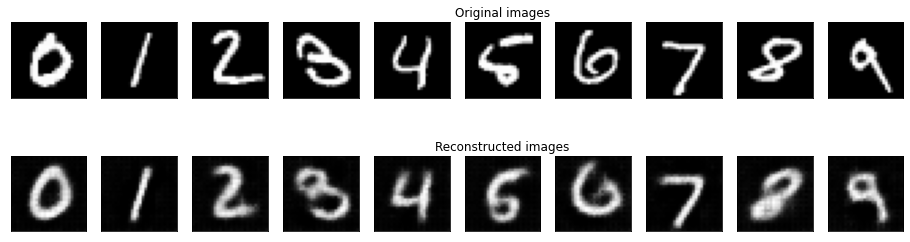

	 partial train loss (single batch): 0.029901
	 partial train loss (single batch): 0.029053
	 partial train loss (single batch): 0.029586
	 partial train loss (single batch): 0.029617
	 partial train loss (single batch): 0.029490
	 partial train loss (single batch): 0.026834
	 partial train loss (single batch): 0.026953
	 partial train loss (single batch): 0.029095
	 partial train loss (single batch): 0.030129
	 partial train loss (single batch): 0.026809
	 partial train loss (single batch): 0.030469
	 partial train loss (single batch): 0.029446
	 partial train loss (single batch): 0.030063
	 partial train loss (single batch): 0.027759
	 partial train loss (single batch): 0.030582
	 partial train loss (single batch): 0.029951
	 partial train loss (single batch): 0.027872
	 partial train loss (single batch): 0.029413
	 partial train loss (single batch): 0.028169
	 partial train loss (single batch): 0.030439
	 partial train loss (single batch): 0.029143
	 partial train loss (single batch

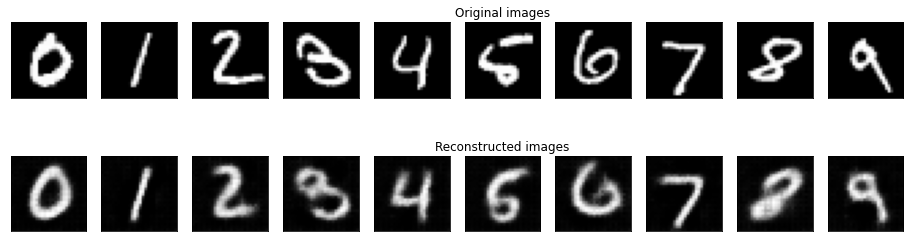

	 partial train loss (single batch): 0.029477
	 partial train loss (single batch): 0.028511
	 partial train loss (single batch): 0.029223
	 partial train loss (single batch): 0.029122
	 partial train loss (single batch): 0.029071
	 partial train loss (single batch): 0.026424
	 partial train loss (single batch): 0.026480
	 partial train loss (single batch): 0.028846
	 partial train loss (single batch): 0.029777
	 partial train loss (single batch): 0.026627
	 partial train loss (single batch): 0.030051
	 partial train loss (single batch): 0.029110
	 partial train loss (single batch): 0.029518
	 partial train loss (single batch): 0.027381
	 partial train loss (single batch): 0.030101
	 partial train loss (single batch): 0.029513
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.027725
	 partial train loss (single batch): 0.029912
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch

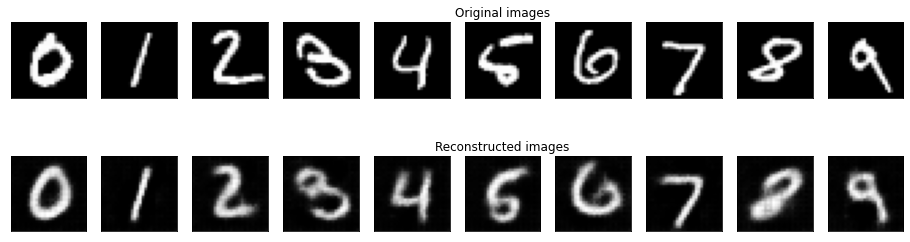

	 partial train loss (single batch): 0.029179
	 partial train loss (single batch): 0.028092
	 partial train loss (single batch): 0.028906
	 partial train loss (single batch): 0.028849
	 partial train loss (single batch): 0.028691
	 partial train loss (single batch): 0.026052
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.028362
	 partial train loss (single batch): 0.029359
	 partial train loss (single batch): 0.026228
	 partial train loss (single batch): 0.029803
	 partial train loss (single batch): 0.028778
	 partial train loss (single batch): 0.029207
	 partial train loss (single batch): 0.027117
	 partial train loss (single batch): 0.029868
	 partial train loss (single batch): 0.029108
	 partial train loss (single batch): 0.027073
	 partial train loss (single batch): 0.028804
	 partial train loss (single batch): 0.027408
	 partial train loss (single batch): 0.029501
	 partial train loss (single batch): 0.028356
	 partial train loss (single batch

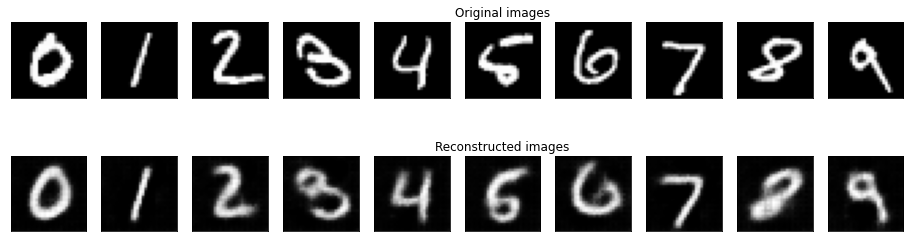

	 partial train loss (single batch): 0.028915
	 partial train loss (single batch): 0.027847
	 partial train loss (single batch): 0.028697
	 partial train loss (single batch): 0.028538
	 partial train loss (single batch): 0.028446
	 partial train loss (single batch): 0.025780
	 partial train loss (single batch): 0.025863
	 partial train loss (single batch): 0.028159
	 partial train loss (single batch): 0.029174
	 partial train loss (single batch): 0.025919
	 partial train loss (single batch): 0.029530
	 partial train loss (single batch): 0.028477
	 partial train loss (single batch): 0.028926
	 partial train loss (single batch): 0.026851
	 partial train loss (single batch): 0.029693
	 partial train loss (single batch): 0.028791
	 partial train loss (single batch): 0.026843
	 partial train loss (single batch): 0.028663
	 partial train loss (single batch): 0.027143
	 partial train loss (single batch): 0.029182
	 partial train loss (single batch): 0.028079
	 partial train loss (single batch

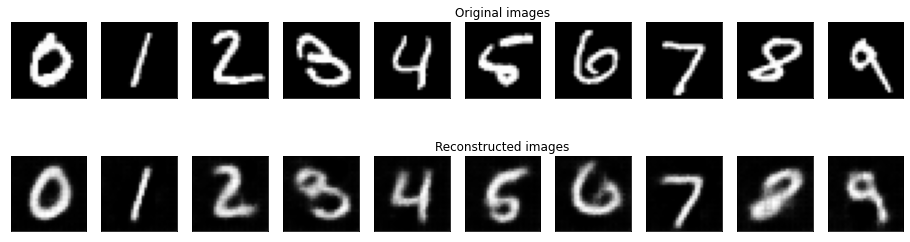

	 partial train loss (single batch): 0.028684
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.028474
	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.028220
	 partial train loss (single batch): 0.025546
	 partial train loss (single batch): 0.025612
	 partial train loss (single batch): 0.027976
	 partial train loss (single batch): 0.028915
	 partial train loss (single batch): 0.025669
	 partial train loss (single batch): 0.029308
	 partial train loss (single batch): 0.028195
	 partial train loss (single batch): 0.028666
	 partial train loss (single batch): 0.026600
	 partial train loss (single batch): 0.029478
	 partial train loss (single batch): 0.028440
	 partial train loss (single batch): 0.026629
	 partial train loss (single batch): 0.028567
	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.028915
	 partial train loss (single batch): 0.027812
	 partial train loss (single batch

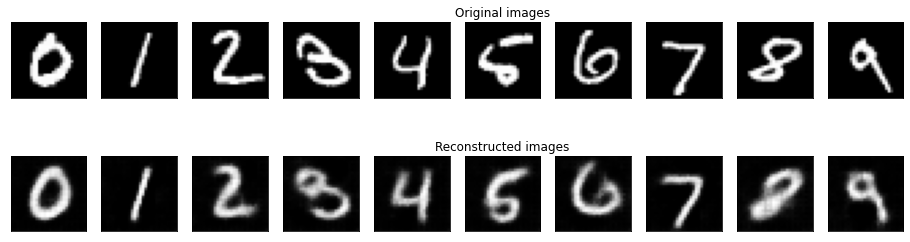

	 partial train loss (single batch): 0.028452
	 partial train loss (single batch): 0.027197
	 partial train loss (single batch): 0.028189
	 partial train loss (single batch): 0.028053
	 partial train loss (single batch): 0.028029
	 partial train loss (single batch): 0.025360
	 partial train loss (single batch): 0.025310
	 partial train loss (single batch): 0.027699
	 partial train loss (single batch): 0.028752
	 partial train loss (single batch): 0.025476
	 partial train loss (single batch): 0.029065
	 partial train loss (single batch): 0.027987
	 partial train loss (single batch): 0.028476
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.029215
	 partial train loss (single batch): 0.028167
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.028262
	 partial train loss (single batch): 0.026676
	 partial train loss (single batch): 0.028608
	 partial train loss (single batch): 0.027577
	 partial train loss (single batch

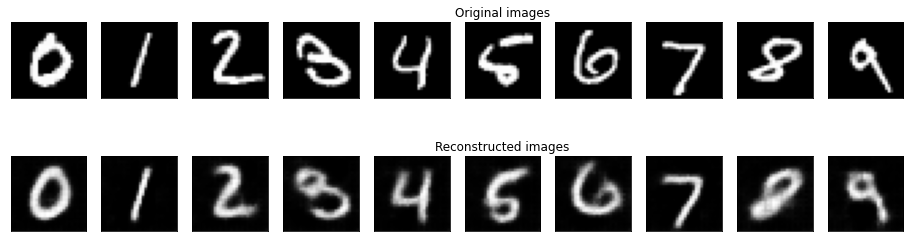

	 partial train loss (single batch): 0.028371
	 partial train loss (single batch): 0.027079
	 partial train loss (single batch): 0.028041
	 partial train loss (single batch): 0.027899
	 partial train loss (single batch): 0.027886
	 partial train loss (single batch): 0.025142
	 partial train loss (single batch): 0.025167
	 partial train loss (single batch): 0.027523
	 partial train loss (single batch): 0.028627
	 partial train loss (single batch): 0.025291
	 partial train loss (single batch): 0.028967
	 partial train loss (single batch): 0.027807
	 partial train loss (single batch): 0.028305
	 partial train loss (single batch): 0.026239
	 partial train loss (single batch): 0.029097
	 partial train loss (single batch): 0.027908
	 partial train loss (single batch): 0.026262
	 partial train loss (single batch): 0.028131
	 partial train loss (single batch): 0.026461
	 partial train loss (single batch): 0.028456
	 partial train loss (single batch): 0.027444
	 partial train loss (single batch

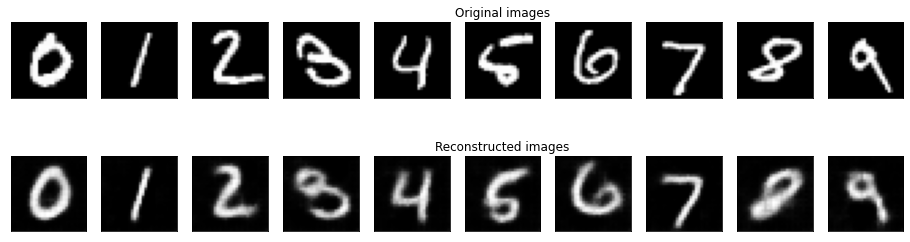

	 partial train loss (single batch): 0.028198
	 partial train loss (single batch): 0.026774
	 partial train loss (single batch): 0.027850
	 partial train loss (single batch): 0.027669
	 partial train loss (single batch): 0.027618
	 partial train loss (single batch): 0.024933
	 partial train loss (single batch): 0.025035
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.028408
	 partial train loss (single batch): 0.025110
	 partial train loss (single batch): 0.028823
	 partial train loss (single batch): 0.027707
	 partial train loss (single batch): 0.028182
	 partial train loss (single batch): 0.026130
	 partial train loss (single batch): 0.028893
	 partial train loss (single batch): 0.027704
	 partial train loss (single batch): 0.026102
	 partial train loss (single batch): 0.027969
	 partial train loss (single batch): 0.026269
	 partial train loss (single batch): 0.028199
	 partial train loss (single batch): 0.027258
	 partial train loss (single batch

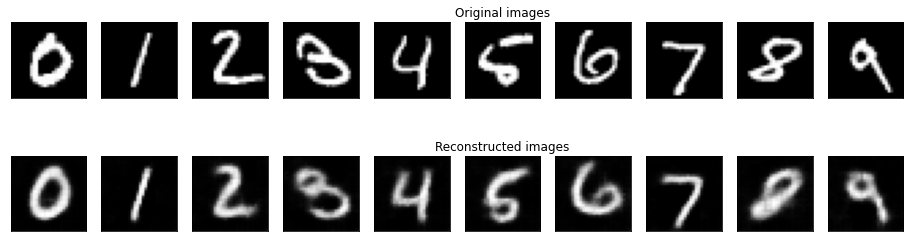

	 partial train loss (single batch): 0.028038
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.027596
	 partial train loss (single batch): 0.027479
	 partial train loss (single batch): 0.027483
	 partial train loss (single batch): 0.024770
	 partial train loss (single batch): 0.024825
	 partial train loss (single batch): 0.027138
	 partial train loss (single batch): 0.028253
	 partial train loss (single batch): 0.024977
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch): 0.027553
	 partial train loss (single batch): 0.027996
	 partial train loss (single batch): 0.025922
	 partial train loss (single batch): 0.028772
	 partial train loss (single batch): 0.027577
	 partial train loss (single batch): 0.025991
	 partial train loss (single batch): 0.027790
	 partial train loss (single batch): 0.026163
	 partial train loss (single batch): 0.028021
	 partial train loss (single batch): 0.027114
	 partial train loss (single batch

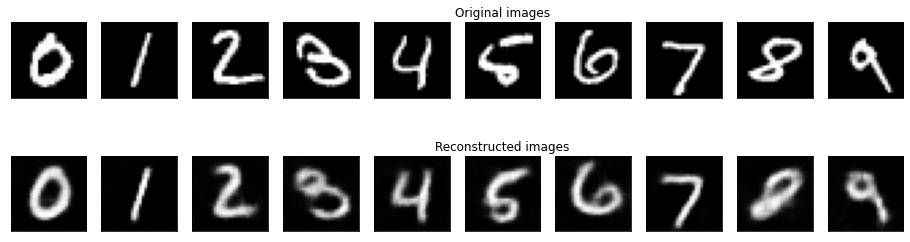

	 partial train loss (single batch): 0.027882
	 partial train loss (single batch): 0.026444
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.027302
	 partial train loss (single batch): 0.027333
	 partial train loss (single batch): 0.024595
	 partial train loss (single batch): 0.024670
	 partial train loss (single batch): 0.027030
	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.024844
	 partial train loss (single batch): 0.028611
	 partial train loss (single batch): 0.027429
	 partial train loss (single batch): 0.027885
	 partial train loss (single batch): 0.025755
	 partial train loss (single batch): 0.028607
	 partial train loss (single batch): 0.027369
	 partial train loss (single batch): 0.025845
	 partial train loss (single batch): 0.027638
	 partial train loss (single batch): 0.025939
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch

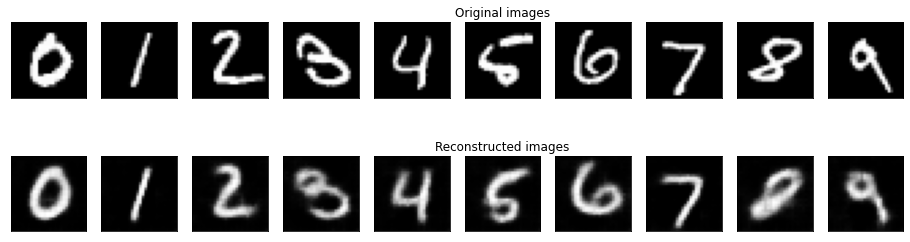

	 partial train loss (single batch): 0.027754
	 partial train loss (single batch): 0.026340
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.027185
	 partial train loss (single batch): 0.024488
	 partial train loss (single batch): 0.024558
	 partial train loss (single batch): 0.026941
	 partial train loss (single batch): 0.027995
	 partial train loss (single batch): 0.024756
	 partial train loss (single batch): 0.028498
	 partial train loss (single batch): 0.027325
	 partial train loss (single batch): 0.027807
	 partial train loss (single batch): 0.025625
	 partial train loss (single batch): 0.028467
	 partial train loss (single batch): 0.027156
	 partial train loss (single batch): 0.025738
	 partial train loss (single batch): 0.027570
	 partial train loss (single batch): 0.025804
	 partial train loss (single batch): 0.027697
	 partial train loss (single batch): 0.026891
	 partial train loss (single batch

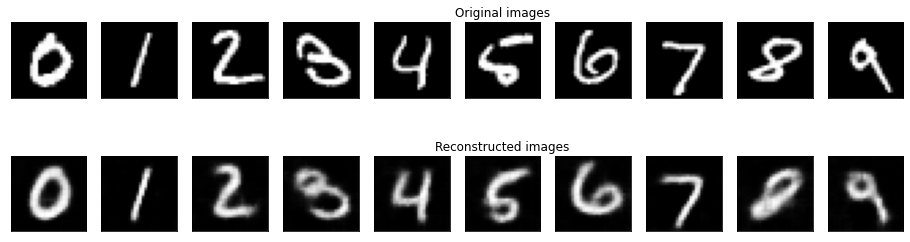

	 partial train loss (single batch): 0.027669
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.027189
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.027107
	 partial train loss (single batch): 0.024405
	 partial train loss (single batch): 0.024487
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.027856
	 partial train loss (single batch): 0.024688
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.025518
	 partial train loss (single batch): 0.028376
	 partial train loss (single batch): 0.027098
	 partial train loss (single batch): 0.025668
	 partial train loss (single batch): 0.027452
	 partial train loss (single batch): 0.025643
	 partial train loss (single batch): 0.027534
	 partial train loss (single batch): 0.026780
	 partial train loss (single batch

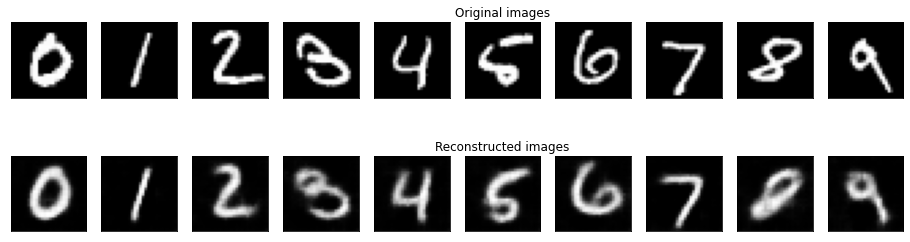

	 partial train loss (single batch): 0.027467
	 partial train loss (single batch): 0.026064
	 partial train loss (single batch): 0.027120
	 partial train loss (single batch): 0.026834
	 partial train loss (single batch): 0.026981
	 partial train loss (single batch): 0.024275
	 partial train loss (single batch): 0.024340
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.027839
	 partial train loss (single batch): 0.024610
	 partial train loss (single batch): 0.028281
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch): 0.027534
	 partial train loss (single batch): 0.025486
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.025553
	 partial train loss (single batch): 0.027351
	 partial train loss (single batch): 0.025476
	 partial train loss (single batch): 0.027454
	 partial train loss (single batch): 0.026669
	 partial train loss (single batch

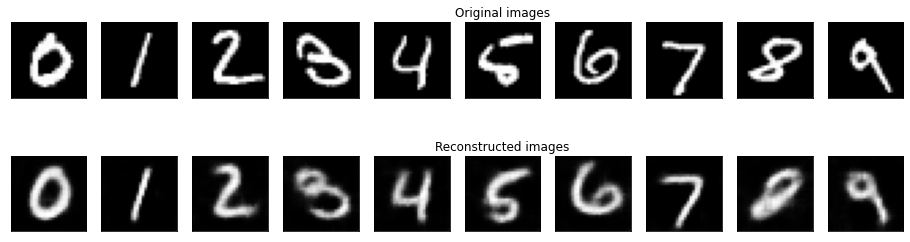

	 partial train loss (single batch): 0.027362
	 partial train loss (single batch): 0.025979
	 partial train loss (single batch): 0.027053
	 partial train loss (single batch): 0.026729
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.024154
	 partial train loss (single batch): 0.024202
	 partial train loss (single batch): 0.026715
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.024485
	 partial train loss (single batch): 0.028240
	 partial train loss (single batch): 0.026989
	 partial train loss (single batch): 0.027362
	 partial train loss (single batch): 0.025364
	 partial train loss (single batch): 0.028175
	 partial train loss (single batch): 0.026850
	 partial train loss (single batch): 0.025415
	 partial train loss (single batch): 0.027250
	 partial train loss (single batch): 0.025373
	 partial train loss (single batch): 0.027388
	 partial train loss (single batch): 0.026596
	 partial train loss (single batch

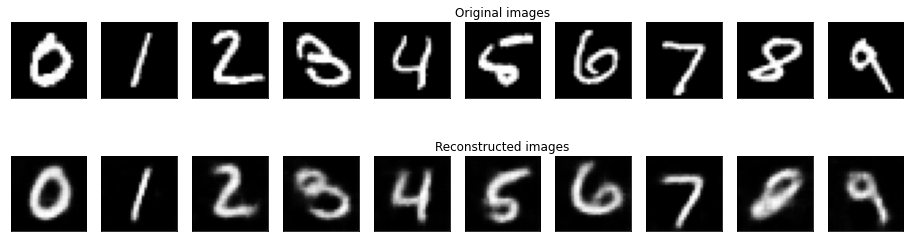

	 partial train loss (single batch): 0.027290
	 partial train loss (single batch): 0.025900
	 partial train loss (single batch): 0.027031
	 partial train loss (single batch): 0.026611
	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.024086
	 partial train loss (single batch): 0.024143
	 partial train loss (single batch): 0.026592
	 partial train loss (single batch): 0.027603
	 partial train loss (single batch): 0.024425
	 partial train loss (single batch): 0.028094
	 partial train loss (single batch): 0.026831
	 partial train loss (single batch): 0.027293
	 partial train loss (single batch): 0.025328
	 partial train loss (single batch): 0.028066
	 partial train loss (single batch): 0.026739
	 partial train loss (single batch): 0.025326
	 partial train loss (single batch): 0.027169
	 partial train loss (single batch): 0.025288
	 partial train loss (single batch): 0.027235
	 partial train loss (single batch): 0.026495
	 partial train loss (single batch

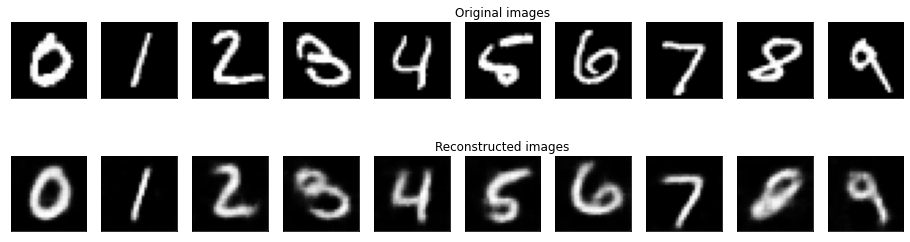

	 partial train loss (single batch): 0.027166
	 partial train loss (single batch): 0.025818
	 partial train loss (single batch): 0.026967
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026724
	 partial train loss (single batch): 0.024002
	 partial train loss (single batch): 0.024119
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.027507
	 partial train loss (single batch): 0.024320
	 partial train loss (single batch): 0.027998
	 partial train loss (single batch): 0.026775
	 partial train loss (single batch): 0.027167
	 partial train loss (single batch): 0.025291
	 partial train loss (single batch): 0.027927
	 partial train loss (single batch): 0.026632
	 partial train loss (single batch): 0.025212
	 partial train loss (single batch): 0.027056
	 partial train loss (single batch): 0.025176
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.026387
	 partial train loss (single batch

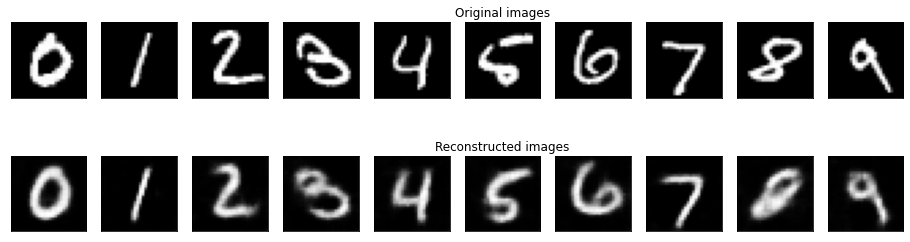

	 partial train loss (single batch): 0.027117
	 partial train loss (single batch): 0.025732
	 partial train loss (single batch): 0.026943
	 partial train loss (single batch): 0.026417
	 partial train loss (single batch): 0.026718
	 partial train loss (single batch): 0.023911
	 partial train loss (single batch): 0.024022
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.024199
	 partial train loss (single batch): 0.027879
	 partial train loss (single batch): 0.026558
	 partial train loss (single batch): 0.027027
	 partial train loss (single batch): 0.025176
	 partial train loss (single batch): 0.027876
	 partial train loss (single batch): 0.026533
	 partial train loss (single batch): 0.025181
	 partial train loss (single batch): 0.026950
	 partial train loss (single batch): 0.025084
	 partial train loss (single batch): 0.027112
	 partial train loss (single batch): 0.026312
	 partial train loss (single batch

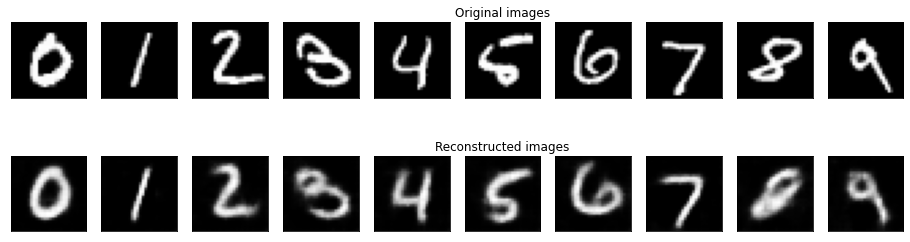

	 partial train loss (single batch): 0.026945
	 partial train loss (single batch): 0.025674
	 partial train loss (single batch): 0.026940
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.026745
	 partial train loss (single batch): 0.023847
	 partial train loss (single batch): 0.023951
	 partial train loss (single batch): 0.026365
	 partial train loss (single batch): 0.027357
	 partial train loss (single batch): 0.024171
	 partial train loss (single batch): 0.027775
	 partial train loss (single batch): 0.026576
	 partial train loss (single batch): 0.026912
	 partial train loss (single batch): 0.025111
	 partial train loss (single batch): 0.027919
	 partial train loss (single batch): 0.026484
	 partial train loss (single batch): 0.025121
	 partial train loss (single batch): 0.026838
	 partial train loss (single batch): 0.024940
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.026265
	 partial train loss (single batch

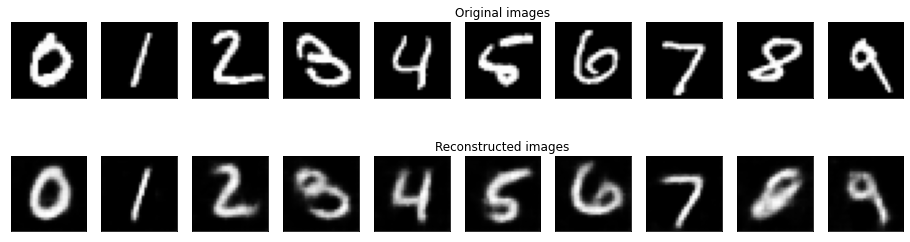

	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.025581
	 partial train loss (single batch): 0.026877
	 partial train loss (single batch): 0.026284
	 partial train loss (single batch): 0.026680
	 partial train loss (single batch): 0.023745
	 partial train loss (single batch): 0.023882
	 partial train loss (single batch): 0.026268
	 partial train loss (single batch): 0.027229
	 partial train loss (single batch): 0.024053
	 partial train loss (single batch): 0.027668
	 partial train loss (single batch): 0.026493
	 partial train loss (single batch): 0.026845
	 partial train loss (single batch): 0.025024
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.026341
	 partial train loss (single batch): 0.025001
	 partial train loss (single batch): 0.026789
	 partial train loss (single batch): 0.024897
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.026212
	 partial train loss (single batch

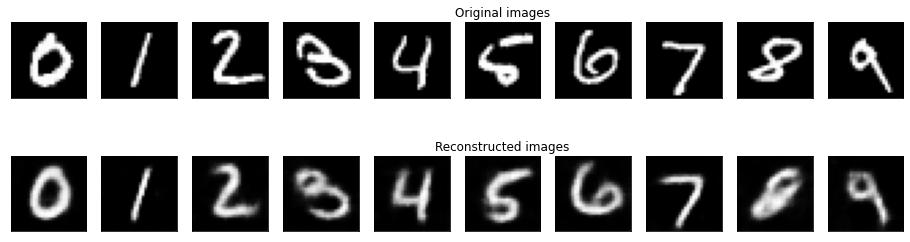

	 partial train loss (single batch): 0.026771
	 partial train loss (single batch): 0.025473
	 partial train loss (single batch): 0.026813
	 partial train loss (single batch): 0.026184
	 partial train loss (single batch): 0.026620
	 partial train loss (single batch): 0.023665
	 partial train loss (single batch): 0.023792
	 partial train loss (single batch): 0.026141
	 partial train loss (single batch): 0.027115
	 partial train loss (single batch): 0.023946
	 partial train loss (single batch): 0.027581
	 partial train loss (single batch): 0.026447
	 partial train loss (single batch): 0.026730
	 partial train loss (single batch): 0.024874
	 partial train loss (single batch): 0.027746
	 partial train loss (single batch): 0.026317
	 partial train loss (single batch): 0.024893
	 partial train loss (single batch): 0.026768
	 partial train loss (single batch): 0.024792
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.026117
	 partial train loss (single batch

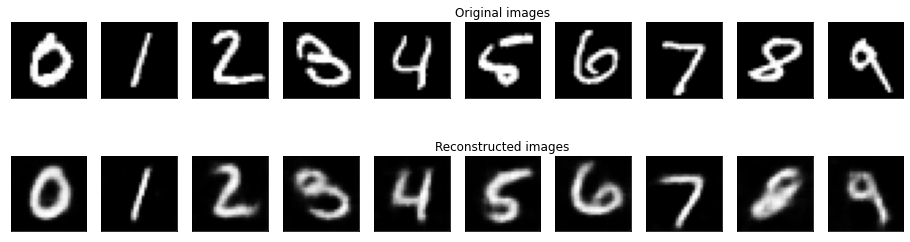

	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.025317
	 partial train loss (single batch): 0.026699
	 partial train loss (single batch): 0.026127
	 partial train loss (single batch): 0.026503
	 partial train loss (single batch): 0.023595
	 partial train loss (single batch): 0.023776
	 partial train loss (single batch): 0.026092
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.023886
	 partial train loss (single batch): 0.027486
	 partial train loss (single batch): 0.026384
	 partial train loss (single batch): 0.026642
	 partial train loss (single batch): 0.024870
	 partial train loss (single batch): 0.027624
	 partial train loss (single batch): 0.026301
	 partial train loss (single batch): 0.024851
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.024782
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.026125
	 partial train loss (single batch

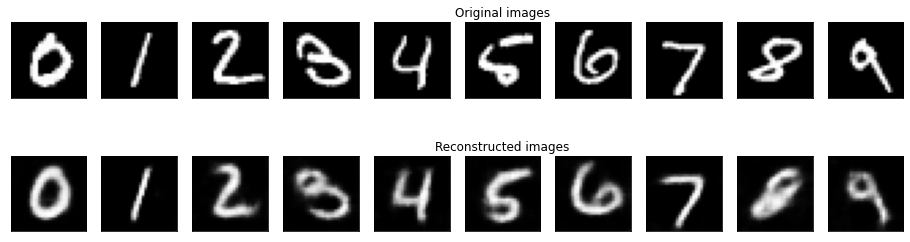

	 partial train loss (single batch): 0.026631
	 partial train loss (single batch): 0.025256
	 partial train loss (single batch): 0.026665
	 partial train loss (single batch): 0.025985
	 partial train loss (single batch): 0.026403
	 partial train loss (single batch): 0.023575
	 partial train loss (single batch): 0.023702
	 partial train loss (single batch): 0.025925
	 partial train loss (single batch): 0.026930
	 partial train loss (single batch): 0.023811
	 partial train loss (single batch): 0.027466
	 partial train loss (single batch): 0.026349
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.024644
	 partial train loss (single batch): 0.027579
	 partial train loss (single batch): 0.026206
	 partial train loss (single batch): 0.024806
	 partial train loss (single batch): 0.026636
	 partial train loss (single batch): 0.024731
	 partial train loss (single batch): 0.026650
	 partial train loss (single batch): 0.026008
	 partial train loss (single batch

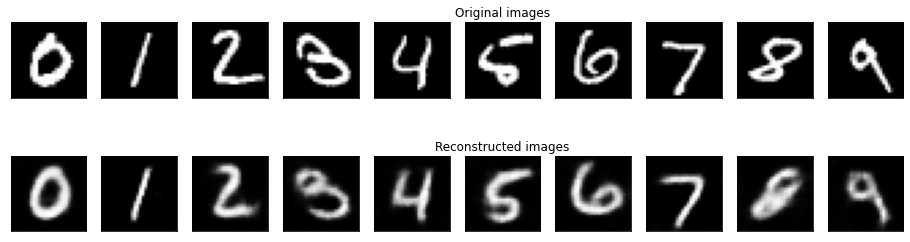

In [12]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =CA.train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = CA.test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print(val_loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [13]:
CA.test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026711255311965942

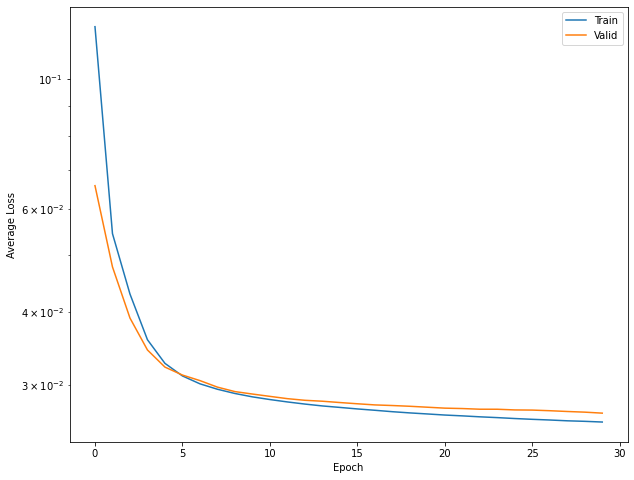

In [14]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.2731,  0.2092,  0.2830,  0.0329])
tensor([0.7405, 0.8326, 0.7413, 0.5490])


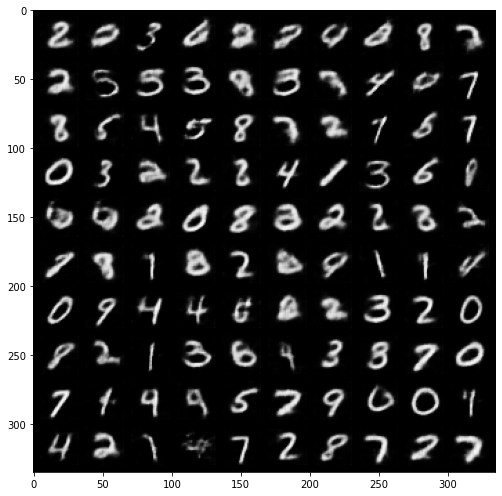

In [16]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()